In [1]:
import pickle
import math

import torch
import numpy as np
from veccs import orderings
from gpytorch.kernels import MaternKernel
from sklearn.gaussian_process import kernels
from matplotlib import pyplot as plt

from batram.legmods import Data, SimpleTM
from batram.shrinkmods import ShrinkTM, EstimableShrinkTM

%load_ext autoreload
%autoreload 2

/home/anirban0451/miniconda3/envs/shrink2param/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Reading data

In [2]:

with open("../data/prec_days.pkl", "rb") as f:
    prec_days = pickle.load(f)

#with open("../data/prec_all.pkl", "rb") as f:
#    prec_all = pickle.load(f)

lat = prec_days["lat"]
lon = prec_days["lon"]
obs = np.log(prec_days["precs"][:,:,0].T + 1e-10)
obs_orig = obs.copy()
locs = np.loadtxt("../data/locs.csv", skiprows=1, delimiter=",")
lat = locs[:, 1]
lon = locs[:, 0]
#obs = np.loadtxt("../data/prec-june1.csv", skiprows=1, delimiter=",").T
#l=lon/360*2*math.pi; L=lat/360*2*math.pi
#locs = (np.vstack([np.cos(L)*np.cos(l),np.cos(L)*np.sin(l),np.sin(L)])).T

In [3]:
#newline
#l=(lon/360)*2*math.pi; L=(lat/360)*2*math.pi
#locs=np.vstack([np.cos(L)*np.cos(l),np.cos(L)*np.sin(l),np.sin(L)]).T

In [4]:
#newline
obsmean = np.mean(obs, axis=0, keepdims=True)
obdsd = np.std(obs, axis=0, keepdims=True)

In [5]:
#newline
obs = (obs - obsmean) / obdsd

In [6]:
#np.std(obs, axis = 0)

### Ordering

In [7]:
torch.manual_seed(6132024)
locsorder = orderings.maxmin_cpp(locs)
locsTrain = locs[locsorder, :]
nn = orderings.find_nns_l2(locsTrain, 30)
shuffle = torch.randperm(obs.shape[0])

obsTrain = torch.from_numpy((obs[shuffle,:])[:, locsorder]).float()

In [8]:
#newline
#nsteps = 200
#data = Data.new(torch.as_tensor(locsTrain).float(), torch.from_numpy(obs[0:2, :]).float(), torch.as_tensor(nn))

#tm = SimpleTM(data, theta_init=torch.Tensor([-5, 0.2, 0.0, 0.0, 0.0, -1.0]), 
#              linear=False, smooth=1.5, nug_mult=4.0)
#opt = torch.optim.Adam(tm.parameters(), lr=0.01)
#sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, nsteps)
#res = tm.fit(
#    nsteps, 0.1, test_data=tm.data, optimizer=opt, scheduler=sched, batch_size=900
#)

### Training

In [9]:
nsteps = 200
nTrain = [1, 3, 5, 10, 20, 35, 50, 80]

In [10]:
logscores_tm = []
logscores_shrink = []
numExpReps = 10
tm_models = []
shrink_models = []
numTestSamples = 50
ModifNumTestSampleslist = []

In [11]:
MasterIndices = np.arange(obsTrain.shape[0])
for n in nTrain:
    
    ActNumTestSamples = min(numTestSamples, (obsTrain.shape[0] - n))
    logScore_tm = torch.zeros(numExpReps)
    logScore_shrink = torch.zeros(numExpReps)
    ModifNumTestSamples = (ActNumTestSamples * torch.ones(numExpReps))
    for i in range(numExpReps):
        indices = np.random.choice(MasterIndices, n, replace=False)
        obsTrainSub = obsTrain[indices, :]
        if obsTrainSub.dim() == 1:
            obsTrainSub = obsTrainSub.unsqueeze(0)

        data = Data.new(torch.as_tensor(locsTrain).float(), obsTrainSub, torch.as_tensor(nn))

        tm = SimpleTM(data, theta_init=None, linear=False, smooth=1.5, nug_mult=4.0)
        opt = torch.optim.Adam(tm.parameters(), lr=0.01)
        sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, nsteps)
        res = tm.fit(
            nsteps, 0.1, test_data=tm.data, optimizer=opt, scheduler=sched, batch_size=900
        )

        shrink_tm = EstimableShrinkTM(data=data, linear=False, 
                            transportmap_smooth=1.5, 
                            parametric_kernel= "exponential",
                            param_nu=0.5,
                            param_ls=0.6,
                            nug_mult_bounded=False)
        opt2 = torch.optim.Adam(shrink_tm.parameters(), lr=0.01)
        sched2 = torch.optim.lr_scheduler.CosineAnnealingLR(opt2, nsteps)
        res2 = shrink_tm.fit(
            nsteps, 0.1, test_data=shrink_tm.data, optimizer=opt2, scheduler=sched2, batch_size=900,

        )
        tm_models.append(tm)
        shrink_models.append(shrink_tm)
        TestIndices = np.setdiff1d(MasterIndices, indices)
        for _j in range(ActNumTestSamples):
            try:
                with torch.no_grad():
                    logScore_tm[i] += tm.score(obsTrain[(TestIndices[_j]), :])
                logScore_shrink[i] += shrink_tm.score(obsTrain[(TestIndices[_j]), :])
            except:
                ModifNumTestSamples[i] -= 1
                continue
        print(f"{i}th experiment with {n} training samples done.")
    ModifNumTestSampleslist.append(ModifNumTestSamples)
    logscores_tm.append(logScore_tm)
    logscores_shrink.append(logScore_shrink)
        

Train Loss: -990.925, Test Loss: -988.482: 100%|██████████| 200/200 [00:41<00:00,  4.85it/s] 


0th experiment with 1 training samples done.


Train Loss: -1439.788, Test Loss: -1441.139: 100%|██████████| 200/200 [00:41<00:00,  4.78it/s]


1th experiment with 1 training samples done.


Train Loss: -1471.230, Test Loss: -1471.392: 100%|██████████| 200/200 [00:41<00:00,  4.80it/s]


2th experiment with 1 training samples done.


Train Loss: -1250.469, Test Loss: -1244.725: 100%|██████████| 200/200 [00:40<00:00,  4.91it/s]


3th experiment with 1 training samples done.


Train Loss: -1630.450, Test Loss: -1634.086: 100%|██████████| 200/200 [00:42<00:00,  4.67it/s]


4th experiment with 1 training samples done.


Train Loss: -1181.384, Test Loss: -1184.332: 100%|██████████| 200/200 [00:42<00:00,  4.71it/s]


5th experiment with 1 training samples done.


Train Loss: -1179.733, Test Loss: -1181.447: 100%|██████████| 200/200 [00:41<00:00,  4.81it/s]


6th experiment with 1 training samples done.


Train Loss: -1044.856, Test Loss: -1042.468: 100%|██████████| 200/200 [00:42<00:00,  4.73it/s]


7th experiment with 1 training samples done.


Train Loss: -1500.650, Test Loss: -1500.912: 100%|██████████| 200/200 [00:41<00:00,  4.77it/s]


8th experiment with 1 training samples done.


Train Loss: -1517.261, Test Loss: -1505.352: 100%|██████████| 200/200 [00:41<00:00,  4.81it/s]


9th experiment with 1 training samples done.


Train Loss: -4171.000, Test Loss: -4160.732: 100%|██████████| 200/200 [00:43<00:00,  4.56it/s]


0th experiment with 3 training samples done.


Train Loss: -3743.339, Test Loss: -3752.974: 100%|██████████| 200/200 [00:44<00:00,  4.54it/s]


1th experiment with 3 training samples done.


Train Loss: -3932.826, Test Loss: -3951.556: 100%|██████████| 200/200 [00:44<00:00,  4.49it/s]


2th experiment with 3 training samples done.


Train Loss: -3920.655, Test Loss: -3912.184: 100%|██████████| 200/200 [00:43<00:00,  4.60it/s]


3th experiment with 3 training samples done.


Train Loss: -3804.906, Test Loss: -3787.244: 100%|██████████| 200/200 [00:44<00:00,  4.52it/s]


4th experiment with 3 training samples done.


Train Loss: -4569.646, Test Loss: -4565.569: 100%|██████████| 200/200 [00:44<00:00,  4.54it/s]


5th experiment with 3 training samples done.


Train Loss: -3903.669, Test Loss: -3914.947: 100%|██████████| 200/200 [00:43<00:00,  4.57it/s]


6th experiment with 3 training samples done.


Train Loss: -3799.002, Test Loss: -3806.540: 100%|██████████| 200/200 [00:43<00:00,  4.58it/s]


7th experiment with 3 training samples done.


Train Loss: -3358.477, Test Loss: -3361.537: 100%|██████████| 200/200 [00:44<00:00,  4.47it/s]


8th experiment with 3 training samples done.


Train Loss: -4146.238, Test Loss: -4145.869: 100%|██████████| 200/200 [00:44<00:00,  4.53it/s]


9th experiment with 3 training samples done.


Train Loss: -6399.567, Test Loss: -6406.740: 100%|██████████| 200/200 [00:45<00:00,  4.37it/s]


0th experiment with 5 training samples done.


Train Loss: -5822.477, Test Loss: -5842.667: 100%|██████████| 200/200 [00:44<00:00,  4.45it/s]


1th experiment with 5 training samples done.


Train Loss: -6119.467, Test Loss: -6082.329: 100%|██████████| 200/200 [00:45<00:00,  4.37it/s]


2th experiment with 5 training samples done.


Train Loss: -5869.437, Test Loss: -5864.466: 100%|██████████| 200/200 [00:44<00:00,  4.46it/s]


3th experiment with 5 training samples done.


Train Loss: -6848.029, Test Loss: -6850.935: 100%|██████████| 200/200 [00:44<00:00,  4.49it/s]


4th experiment with 5 training samples done.


Train Loss: -5953.215, Test Loss: -5917.223: 100%|██████████| 200/200 [00:44<00:00,  4.45it/s]


5th experiment with 5 training samples done.


Train Loss: -6626.416, Test Loss: -6654.217: 100%|██████████| 200/200 [00:45<00:00,  4.43it/s]


6th experiment with 5 training samples done.


Train Loss: -7489.414, Test Loss: -7522.971: 100%|██████████| 200/200 [00:44<00:00,  4.49it/s]


7th experiment with 5 training samples done.


Train Loss: -6278.622, Test Loss: -6255.151: 100%|██████████| 200/200 [00:45<00:00,  4.37it/s]


8th experiment with 5 training samples done.


Train Loss: -7238.104, Test Loss: -7236.577: 100%|██████████| 200/200 [00:45<00:00,  4.39it/s]


9th experiment with 5 training samples done.


Train Loss: -13975.454, Test Loss: -13914.316: 100%|██████████| 200/200 [00:49<00:00,  4.01it/s]


0th experiment with 10 training samples done.


Train Loss: -13300.372, Test Loss: -13270.931: 100%|██████████| 200/200 [00:51<00:00,  3.89it/s]


1th experiment with 10 training samples done.


Train Loss: -14242.997, Test Loss: -14275.353: 100%|██████████| 200/200 [00:49<00:00,  4.05it/s]


2th experiment with 10 training samples done.


Train Loss: -14295.843, Test Loss: -14283.741: 100%|██████████| 200/200 [00:49<00:00,  4.02it/s]


3th experiment with 10 training samples done.


Train Loss: -13846.123, Test Loss: -13834.026: 100%|██████████| 200/200 [00:50<00:00,  3.94it/s]


4th experiment with 10 training samples done.


Train Loss: -13840.383, Test Loss: -13858.611: 100%|██████████| 200/200 [00:51<00:00,  3.87it/s]


5th experiment with 10 training samples done.


Train Loss: -12979.203, Test Loss: -12971.694: 100%|██████████| 200/200 [00:51<00:00,  3.87it/s]


6th experiment with 10 training samples done.


Train Loss: -14134.465, Test Loss: -14111.599: 100%|██████████| 200/200 [00:51<00:00,  3.90it/s]


7th experiment with 10 training samples done.


Train Loss: -14099.631, Test Loss: -14142.887: 100%|██████████| 200/200 [00:50<00:00,  3.96it/s]


8th experiment with 10 training samples done.


Train Loss: -13266.845, Test Loss: -13253.619: 100%|██████████| 200/200 [00:52<00:00,  3.82it/s]


9th experiment with 10 training samples done.


Train Loss: -27041.157, Test Loss: -27090.988: 100%|██████████| 200/200 [00:58<00:00,  3.39it/s]


0th experiment with 20 training samples done.


Train Loss: -28767.246, Test Loss: -28744.180: 100%|██████████| 200/200 [00:59<00:00,  3.37it/s]


1th experiment with 20 training samples done.


Train Loss: -26908.773, Test Loss: -26924.781: 100%|██████████| 200/200 [00:59<00:00,  3.37it/s]


2th experiment with 20 training samples done.


Train Loss: -29230.695, Test Loss: -29160.943: 100%|██████████| 200/200 [00:59<00:00,  3.39it/s]


3th experiment with 20 training samples done.


Train Loss: -28912.590, Test Loss: -28912.186: 100%|██████████| 200/200 [00:58<00:00,  3.39it/s]


4th experiment with 20 training samples done.


Train Loss: -29098.665, Test Loss: -29075.779: 100%|██████████| 200/200 [00:58<00:00,  3.41it/s]


5th experiment with 20 training samples done.


Train Loss: -26523.445, Test Loss: -26559.740: 100%|██████████| 200/200 [00:59<00:00,  3.36it/s]


6th experiment with 20 training samples done.


Train Loss: -26474.036, Test Loss: -26457.473: 100%|██████████| 200/200 [00:59<00:00,  3.39it/s]


7th experiment with 20 training samples done.


Train Loss: -25995.219, Test Loss: -25933.492: 100%|██████████| 200/200 [00:59<00:00,  3.35it/s]


8th experiment with 20 training samples done.


Train Loss: -27139.786, Test Loss: -27069.359: 100%|██████████| 200/200 [00:58<00:00,  3.43it/s]


9th experiment with 20 training samples done.


Train Loss: -50979.255, Test Loss: -50883.812: 100%|██████████| 200/200 [01:30<00:00,  2.21it/s]


0th experiment with 35 training samples done.


Train Loss: -50932.415, Test Loss: -50862.523: 100%|██████████| 200/200 [01:31<00:00,  2.19it/s]


1th experiment with 35 training samples done.


Train Loss: -50265.059, Test Loss: -50352.109: 100%|██████████| 200/200 [01:25<00:00,  2.35it/s]


2th experiment with 35 training samples done.


Train Loss: -50046.302, Test Loss: -50122.418: 100%|██████████| 200/200 [01:31<00:00,  2.19it/s]


3th experiment with 35 training samples done.


Train Loss: -48895.663, Test Loss: -48999.652: 100%|██████████| 200/200 [01:32<00:00,  2.17it/s]


4th experiment with 35 training samples done.


Train Loss: -51600.206, Test Loss: -51690.820: 100%|██████████| 200/200 [01:31<00:00,  2.20it/s]


5th experiment with 35 training samples done.


Train Loss: -49790.882, Test Loss: -49737.578: 100%|██████████| 200/200 [01:31<00:00,  2.18it/s]


6th experiment with 35 training samples done.


Train Loss: -49587.767, Test Loss: -49594.992: 100%|██████████| 200/200 [01:30<00:00,  2.21it/s]


7th experiment with 35 training samples done.


Train Loss: -50823.941, Test Loss: -50651.641: 100%|██████████| 200/200 [01:30<00:00,  2.20it/s]


8th experiment with 35 training samples done.


Train Loss: -50239.689, Test Loss: -50133.434: 100%|██████████| 200/200 [01:32<00:00,  2.16it/s]


9th experiment with 35 training samples done.


Train Loss: -76592.432, Test Loss: -76600.328: 100%|██████████| 200/200 [02:12<00:00,  1.51it/s]


0th experiment with 50 training samples done.


Train Loss: -76556.880, Test Loss: -76828.305: 100%|██████████| 200/200 [02:10<00:00,  1.53it/s]


1th experiment with 50 training samples done.


Train Loss: -75556.372, Test Loss: -75747.438: 100%|██████████| 200/200 [02:12<00:00,  1.51it/s]


2th experiment with 50 training samples done.


Train Loss: -73301.826, Test Loss: -73248.656: 100%|██████████| 200/200 [02:11<00:00,  1.52it/s]


3th experiment with 50 training samples done.


Train Loss: -75026.398, Test Loss: -74987.344: 100%|██████████| 200/200 [02:11<00:00,  1.52it/s]


4th experiment with 50 training samples done.


Train Loss: -73748.911, Test Loss: -73748.438: 100%|██████████| 200/200 [02:10<00:00,  1.53it/s]


5th experiment with 50 training samples done.


Train Loss: -76358.477, Test Loss: -76536.773: 100%|██████████| 200/200 [02:12<00:00,  1.52it/s]


6th experiment with 50 training samples done.


Train Loss: -73679.784, Test Loss: -73802.039: 100%|██████████| 200/200 [02:12<00:00,  1.51it/s]


7th experiment with 50 training samples done.


Train Loss: -76071.602, Test Loss: -75824.906: 100%|██████████| 200/200 [02:11<00:00,  1.52it/s]


8th experiment with 50 training samples done.


Train Loss: -75239.190, Test Loss: -75352.266: 100%|██████████| 200/200 [02:12<00:00,  1.51it/s]


9th experiment with 50 training samples done.


Train Loss: -122715.138, Test Loss: -123051.305: 100%|██████████| 200/200 [04:08<00:00,  1.24s/it]


0th experiment with 80 training samples done.


Train Loss: -124340.440, Test Loss: -124358.680: 100%|██████████| 200/200 [04:15<00:00,  1.28s/it]


1th experiment with 80 training samples done.


Train Loss: -124375.393, Test Loss: -124270.617: 100%|██████████| 200/200 [04:07<00:00,  1.24s/it]


2th experiment with 80 training samples done.


Train Loss: -125362.070, Test Loss: -125471.844: 100%|██████████| 200/200 [04:06<00:00,  1.23s/it]


3th experiment with 80 training samples done.


Train Loss: -124154.047, Test Loss: -124439.312: 100%|██████████| 200/200 [04:05<00:00,  1.23s/it]


4th experiment with 80 training samples done.


Train Loss: -122601.513, Test Loss: -123123.555: 100%|██████████| 200/200 [03:55<00:00,  1.18s/it]


5th experiment with 80 training samples done.


Train Loss: -123969.461, Test Loss: -123928.414: 100%|██████████| 200/200 [03:59<00:00,  1.20s/it]


6th experiment with 80 training samples done.


Train Loss: -125057.120, Test Loss: -125150.547: 100%|██████████| 200/200 [03:57<00:00,  1.19s/it]


7th experiment with 80 training samples done.


Train Loss: -123068.951, Test Loss: -122993.609: 100%|██████████| 200/200 [04:01<00:00,  1.21s/it]


8th experiment with 80 training samples done.


Train Loss: -126728.620, Test Loss: -126507.859: 100%|██████████| 200/200 [04:45<00:00,  1.43s/it]


9th experiment with 80 training samples done.


In [12]:
torch.save({
 'logscores_tm': logscores_tm,
 'logscores_shrink': logscores_shrink,
 'ModifNumTestSampleslist': ModifNumTestSampleslist,
 'nTrain': nTrain,
}, '../results/precipresults_americas.pt')

In [13]:
precipmodels = {
    'tm_models': tm_models,
 'shrink_models': shrink_models,  
}

with open('../results/precipmodels_americas.pkl', 'wb') as f:
    pickle.dump(precipmodels, f)

In [14]:
assert len(logscores_shrink) == len(logscores_tm)
assert len(logscores_shrink) == len(ModifNumTestSampleslist)

### Calculate average log score from experiments

In [15]:
finalscore_tm = torch.zeros((len(logscores_tm[0]), len(nTrain)))
finalscore_shrink = torch.zeros((len(logscores_shrink[0]), len(nTrain)))

In [16]:
for i in range(len(nTrain)):
    finalscore_tm[:, i] = logscores_tm[i] / ModifNumTestSampleslist[i]
    finalscore_shrink[:, i] = logscores_shrink[i] / ModifNumTestSampleslist[i]

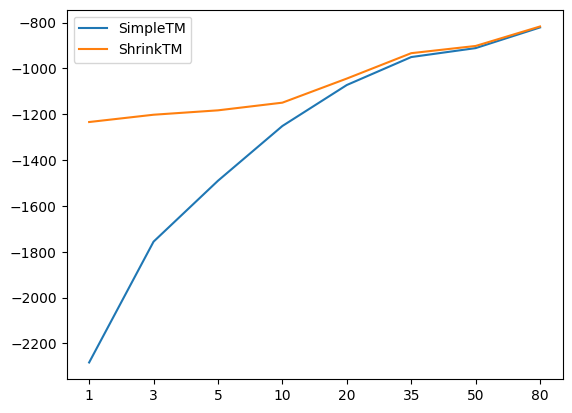

In [17]:
plt.plot(torch.arange(len(nTrain)), finalscore_tm.mean(dim=0), label="SimpleTM")
plt.plot(torch.arange(len(nTrain)), finalscore_shrink.mean(dim=0), label="ShrinkTM")
plt.legend()
plt.xticks(torch.arange(len(nTrain)), labels = nTrain);